In [15]:
%matplotlib notebook

import astropy.constants as const
import numpy as np

from sunpy.coordinates import get_horizons_coord
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from radiospectra import net
from radiospectra.spectrogram2 import Spectrogram
from stixpy.net.client import STIXClient
from stixpy.science import ScienceData

In [2]:
query = Fido.search(a.Time('2021-05-07T16:30', '2021-05-07T20:30'),
                    a.Instrument.xrs | a.Instrument.eovsa | (a.Instrument.stix & a.stix.DataProduct.sci_xray_spec))

/Users/shane/.virtualenvs/rhessi21/lib/python3.7/site-packages/astropy/table/table.py:3197: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


In [3]:
query

<sunpy.net.fido_factory.UnifiedResponse object at 0x116a4ffd0>
Results from 3 Providers:

2 Results from the XRSClient:
       Start Time               End Time        Instrument ... Source Provider
----------------------- ----------------------- ---------- ... ------ --------
2021-05-07 00:00:00.000 2021-05-07 23:59:59.999        XRS ...   GOES     NOAA
2021-05-07 00:00:00.000 2021-05-07 23:59:59.999        XRS ...   GOES     NOAA

2 Results from the EOVSAClient:
       Start Time               End Time        Provider Instrument PolType
----------------------- ----------------------- -------- ---------- -------
2021-05-07 00:00:00.000 2021-05-07 23:59:59.999    EOVSA      EOVSA   Total
2021-05-07 00:00:00.000 2021-05-07 23:59:59.999    EOVSA      EOVSA   Cross

5 Results from the STIXClient:
       Start Time       ...
----------------------- ...
2021-05-07 00:31:34.000 ...
2021-05-07 18:37:38.000 ...
2021-05-07 15:00:11.000 ...
2021-05-07 16:49:11.000 ...
2021-05-07 18:38:38.000 ...

In [4]:
goes_file = Fido.fetch(query[0][1])
eovsa_file = Fido.fetch(query[1][1])
stix_file = Fido.fetch(query[2][1])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [38]:
eosa_spec = Spectrogram(eovsa_file[0])
goes_timeseries = TimeSeries(goes_file[0])
stix_spec = ScienceData.from_fits(stix_file[0])

<EOVSASpectrogram OWENS VALLEY, EOVSA, EOVSA <sunpy.net.attrs.Wavelength(1105371.117591858, 17979686.737060547, 'kHz')>, 2021-05-07T13:48:20.999-2021-05-08T01:50:59.999>

In [6]:

solo_pos = get_horizons_coord('SOLO', time='2021-05-07T19:00')
earth_pos = get_horizons_coord('399', time='2021-05-07T19:00')
light_tt = (solo_pos.radius - earth_pos.radius)/const.c
light_tt.to('s')

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Earth (399) [sunpy.coordinates.ephemeris]


<Quantity -45.82486667 s>

In [7]:
stix_spec.data['time'] = stix_spec.data['time'] - light_tt.to('s')

In [30]:
stix_data_22_70keV = stix_spec.get_data(energy_indices=[[16,26]], time_indices=(np.arange(612)*5).reshape(-1,2))
eovsa_fmask = np.argwhere((eovsa_spec.frequencies.value > 12) & (eovsa_spec.frequencies.value < 15))
eovsa_flux_12_15ghz = eovsa_spec.data[eovsa_fmask].sum(axis=0)

In [35]:
stx_min, stix_max = stix_data_22_70keV[0].reshape(-1).value.min(), stix_data_22_70keV[0].reshape(-1).value.max()

<IPython.core.display.Javascript object>


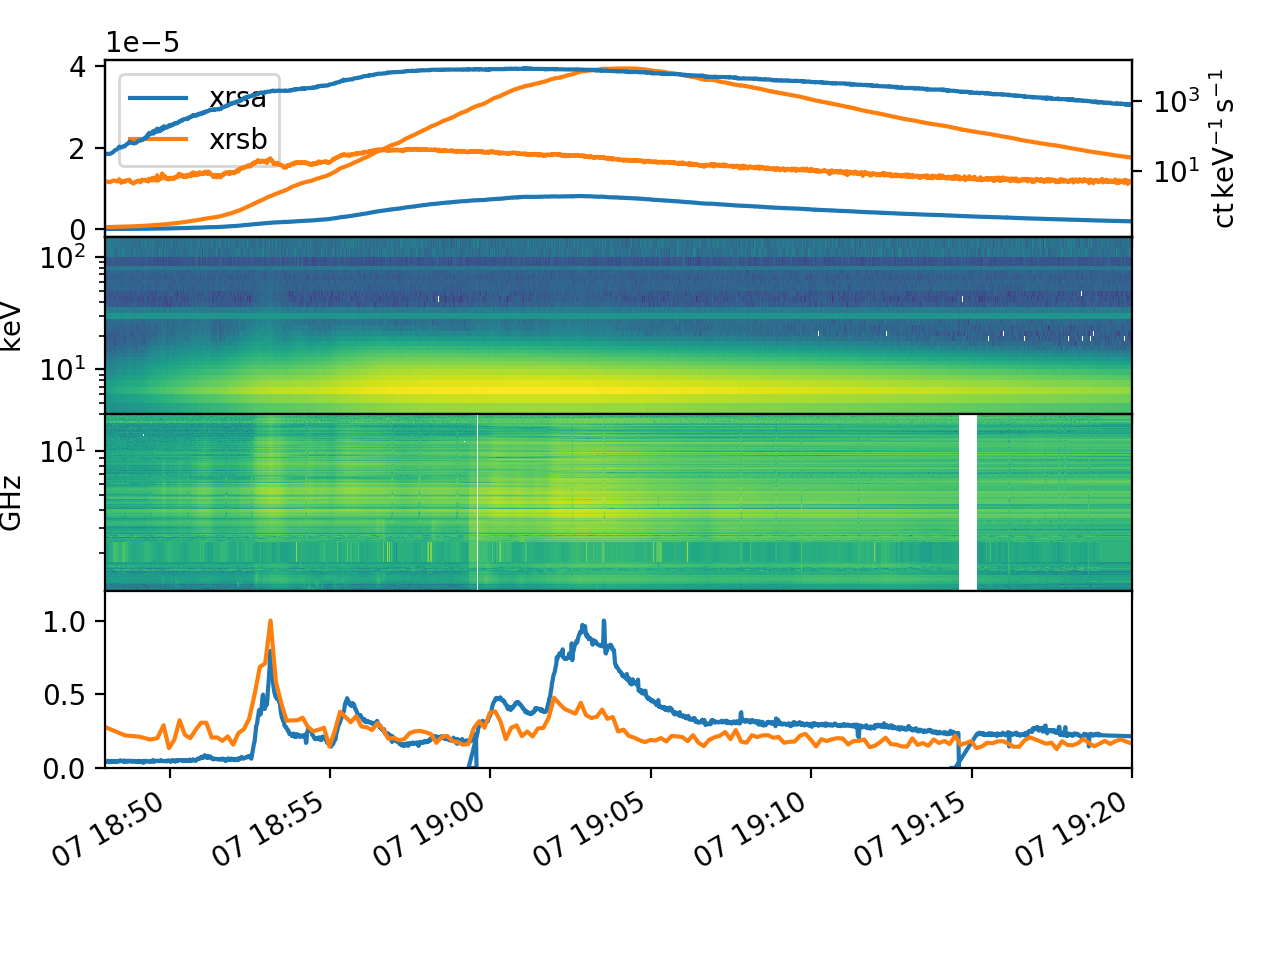

In [37]:

fig, axes = plt.subplots(4, 1, sharex=True, dpi=100)
ax0_twin = axes[0].twinx()
goes_timeseries.plot(axes=axes[0])
stix_spec.plot_timeseries(energy_indices=[[1,10],[10,25]], axes=ax0_twin)
stix_spec.plot_spectrogram(axes=axes[1])
axes[1].set_yscale('log')
eovsa_spec.plot(axes=axes[2], norm=LogNorm())
axes[2].set_title('')
axes[2].set_yscale('log')
axes[2].set_xlim(datetime(2021, 5, 7, 18, 48), datetime(2021, 5, 7, 19, 20))
axes[3].plot(eovsa_spec.times.datetime, eovsa_flux_12_15ghz.reshape(-1)/eovsa_flux_12_15ghz.reshape(-1).max())
axes[3].plot((stix_data_22_70keV[2]).datetime, (stix_data_22_70keV[0].reshape(-1).value-stx_min)/(stix_max-stx_min))
axes[3].set_ylim(0, 1.2)
fig.subplots_adjust(hspace=0)